# 데이터 살펴보기

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
path_to_annotation = "../input/Oxford-IIIT Pet/annotations/trimaps/"
path_to_image = "../input/Oxford-IIIT Pet/images/"

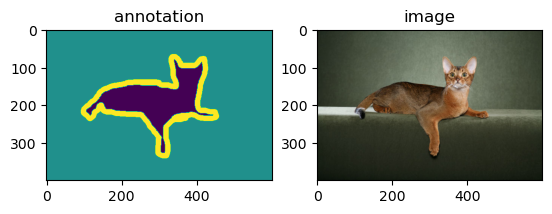

In [3]:
annotation = Image.open(path_to_annotation + "Abyssinian_1.png")
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(path_to_image + "Abyssinian_1.jpg")
plt.subplot(1, 2, 2)
plt.title("image")
plt.imshow(image)

plt.show()

# 학습용 데이터 만들기

In [4]:
import glob

import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset

In [5]:
class Pets(Dataset):
    def __init__(
        self,
        path_to_img,
        path_to_anno,
        train=True,
        transforms=None,
        input_size=(128, 128),
    ):
        self.images = sorted(glob.glob(path_to_img + "/*.jpg"))
        self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))

        self.X_train = self.images[: int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)) :]
        self.Y_train = self.annotations[: int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)) :]

        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)

    def convert_to_rgb(self, img):
        return img.convert("RGB")

    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0  # 배경이 아닌 것들은 1
        mask[mask == 2.0] = 0.0  # 배경은 0
        mask = torch.tensor(mask)
        return mask

    def __getitem__(self, i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.convert_to_rgb(X_train)
            X_train = self.transforms(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.preprocess_mask(Y_train)
            return X_train, Y_train
        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.convert_to_rgb(X_test)
            X_test = self.transforms(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.preprocess_mask(Y_test)
            return X_test, Y_test

# U-Net 모델 정의하기

In [6]:
import torch.nn as nn

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 인코더 은닉층
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        # 디코더 은닉층
        # upsample 시 2 * 2 kernel size, 2 stride를 사용하여 한 번 upsample 시마다 w, h가 두배
        # 4번의 upsample을 거친 후에는 기존 이미지와 가로 세로가 같아진다.
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코딩
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)

        # 디코딩
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)

        return x

# 모델 학습하기

In [8]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
transform = Compose([Resize((128, 128)), ToTensor()])

In [11]:
train_set = Pets(
    path_to_img=path_to_image, path_to_anno=path_to_annotation, transforms=transform
)
test_set = Pets(
    path_to_img=path_to_image,
    path_to_anno=path_to_annotation,
    transforms=transform,
    train=False,
)

In [13]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

In [14]:
model = UNet().to(device)
model

UNet(
  (enc1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc5_1): Conv

In [15]:
lr = 0.0001
optim = Adam(params=model.parameters(), lr=lr)

In [16]:
for epoch in range(200):
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:
        optim.zero_grad()

        preds = model(data.to(device))

        loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch {epoch + 1} loss: {loss.item()}")

epoch 200 loss: 0.021394506096839905: 100%|██████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


In [17]:
torch.save(model.state_dict(), "./UNet.pth")

In [29]:
model.load_state_dict(torch.load("./UNet.pth", weights_only=True, map_location=device))

<All keys matched successfully>

In [30]:
data, label = test_set[1]

In [31]:
with torch.no_grad():
    pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5

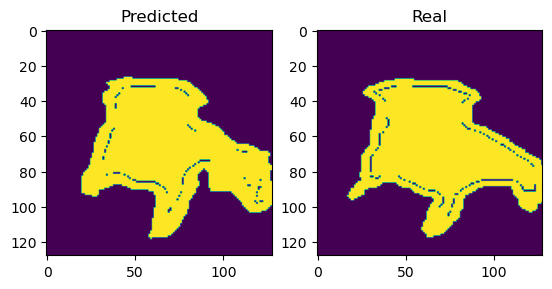

In [32]:
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.imshow(torch.Tensor.cpu(pred))
plt.subplot(1, 2, 2)
plt.title("Real")
plt.imshow(label)
plt.show()